## Import packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from sklearn.metrics import f1_score, accuracy_score

from wordcloud import WordCloud, STOPWORDS
import random
import warnings

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader
from torch.nn.utils import clip_grad_norm_

warnings.filterwarnings('ignore')

#Setting seeds
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cpu')

# Explore data

In [9]:
train = pd.read_csv('train.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [10]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# Cleaning data

In [12]:
def clean_data(text):
    #remove url
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    #remove emoji
    emoji_patterns = re.compile('['
        u'\U0001F600-\U0001F64F'  
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF'  
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    
    text = re.sub(emoji_patterns, '', text)
    
    #remove html
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)
    
    #remove punctuation
    text = re.sub(r'[?!.;:,#@-]', '', text)
    
    #lower text
    text = text.lower()
    
    return text

train['text'] = train['text'].apply(lambda x: clean_data(x))

In [13]:
#remove stop words
stopwords = list(STOPWORDS)
stopwords.append('u')

sentence_without_stopwords = []
for text in train['text']:
    sentence_with_stopwords = text.split(" ")
    
    sentence = " ".join([y for y in sentence_with_stopwords if y not in stopwords])
    sentence_without_stopwords.append(sentence)
    
train['text'] = sentence_without_stopwords
train

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,NaN,NaN,aria_ahrary thetawniest control wild fires cal...,1
7610,10871,NaN,NaN,m194 [0104 utc]5km s volcano hawaii,1
7611,10872,NaN,NaN,police investigating ebike collided car little...,1


In [14]:
#convert nan values to empty string
train['keyword'] = train['keyword'].fillna("")
train['location'] = train['location'].fillna("")

#add keyword to text
train['text'] = train['keyword'] + " " + train['text']

#add location to text
train['text'] = train['location'] + " " + train['text']

In [15]:
train

,id,keyword,location,text,target
0,1,,,deeds reason earthquake may allah forgive us,1
1,4,,,forest fire near la ronge sask canada,1
2,5,,,residents asked 'shelter place' notified off...,1
3,6,,,13000 people receive wildfires evacuation or...,1
4,7,,,got sent photo ruby alaska smoke wildfires p...,1
...,...,...,...,...,...
7608,10869,,,two giant cranes holding bridge collapse nea...,1
7609,10870,,,aria_ahrary thetawniest control wild fires c...,1
7610,10871,,,m194 [0104 utc]5km s volcano hawaii,1
7611,10872,,,police investigating ebike collided car litt...,1


# Visualization

In [16]:
def words_freq(text):
    words = []
    
    for x in text.split():
        words.extend(x)
        
    data = pd.Series(words).value_counts()
    
    return data

freq = words_freq(train['text'].str)
freq

fire               277
will               258
USA                247
now                224
via                223
                  ... 
danhrothschild       1
greed                1
selfdestruction      1
takecare             1
symptoms             1
Length: 22947, dtype: int64

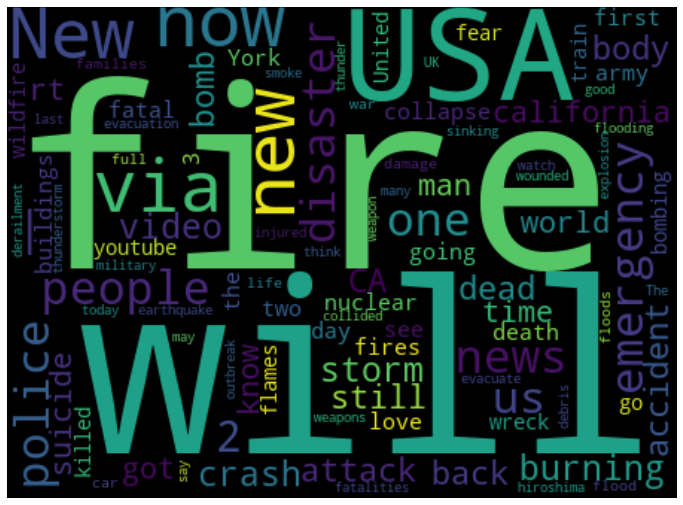

fire         277
will         258
USA          247
now          224
via          223
new          222
New          203
people       194
news         192
emergency    191
dtype: int64

In [17]:
wc = WordCloud(width=450, height=330, max_words=100, background_color='black').generate_from_frequencies(freq)

plt.figure(figsize=(12, 14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

display(freq[:10])

# Tokenizeing

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

max_len = 0
for text in train['text']:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

def BPE_tokenizer(sentence):
    input_ids = []
    attention_masks = []
    
    encoded_dict = tokenizer.encode_plus(
        sentence, 
        add_special_tokens = True, #add '[CLS]' and '[SEP]'
        max_length = max_len, #max len according to text data
        padding = 'max_length', #pad sentences
        truncation = True, #truncate sentences
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
    #convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

Downloading: 100%|██████████| 232k/232k [00:00<00:00, 585kB/s] 
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 14.0kB/s]
Downloading: 100%|██████████| 571/571 [00:00<00:00, 114kB/s]


### Split data into train/validation set 

In [19]:
class SentenceDataset(Dataset):
    def __init__(self, dataset):        
        self.sentences = dataset['text']
        self.targets = dataset['target']
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):        
        sentence, mask = BPE_tokenizer(self.sentences[index])
        target = self.targets[index]
        return sentence, mask, target

In [20]:
dataset = SentenceDataset(train)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

print(f'Train size: {train_size}')
print(f'Valid size: {valid_size}')

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size)

Train size: 6090
Valid size: 1523


# Model

In [21]:
#Load BertForSequenceClassification, the pretrained BERT model

model = BertForSequenceClassification.from_pretrained('bert-large-uncased',
                                                      num_labels = 2, #Number of output labels - 2 for binary classification
                                                      output_attentions = False,
                                                      output_hidden_states = False
                                                     );
model.to(device);

Downloading: 100%|██████████| 1.34G/1.34G [02:12<00:00, 10.1MB/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

In [22]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps = total_steps, num_warmup_steps = 0)

In [23]:
def accuracy(pred, labels):
    pred = np.argmax(pred, axis=1).flatten()
    labels = labels.flatten()
    
    return accuracy_score(labels, pred)

def f1(pred, labels):
    pred = np.argmax(pred, axis=1).flatten()
    labels = labels.flatten()
    
    return f1_score(labels, pred)

In [24]:
training_stats = []

for epoch in range(epochs):
    total_train_loss = 0
    model.train()
    
    #Train
    for i, data in enumerate(train_dataloader):
        input_ids = data[0].to(device).to(torch.int64).squeeze(1)
        input_mask = data[1].to(device).to(torch.int64)
        labels = data[2].to(device).to(torch.int64)  
        model.zero_grad()

        output = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)

        total_train_loss += output['loss'].item()
        
        output['loss'].backward()
        
        clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    #Validation
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    
    for data in valid_dataloader:
        input_ids = data[0].to(device).squeeze(1)
        input_mask = data[1].to(device)
        labels = data[2].to(device)  
        
        with torch.no_grad(): 
            
            output = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            
        total_eval_loss += output['loss'].item()

        logits = output['logits'].detach().cpu().numpy()
        labels_ids = labels.cpu().numpy()

        total_eval_accuracy += accuracy(logits, labels_ids)
        total_eval_f1 += f1(logits, labels_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    avg_val_f1 = total_eval_f1 / len(valid_dataloader)
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1
        }
    )

    print(f"Epoch: {epoch+1}")

print('')
print('Training complete!')

Epoch: 1
Epoch: 2
Epoch: 3

Training complete!


In [26]:
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1
epoch,,,,
1,0.488531,0.414791,0.830249,0.761766
2,0.367216,0.428632,0.836760,0.770493
3,0.282908,0.479950,0.826343,0.774219


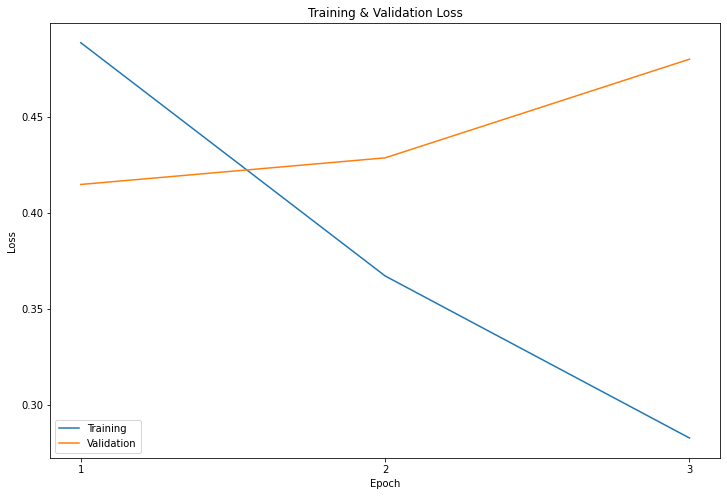

In [27]:
fig, axes = plt.subplots(figsize=(12,8))

plt.plot(df_stats['Training Loss'], label='Training')
plt.plot(df_stats['Valid. Loss'], label='Validation')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# Prediction

In [28]:
class TestSentenceDataset(Dataset):
    def __init__(self, dataset):        
        self.sentences = dataset['text']
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):        
        sentence, mask = BPE_tokenizer(self.sentences[index])
        return sentence, mask
    
test = pd.read_csv('test.csv')

test_dataset = TestSentenceDataset(test)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [29]:
model.eval()

pred = []

for data in test_dataloader:
    input_ids = data[0].to(device).squeeze(1)
    mask = data[1].to(device)
                       
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=mask)
        
    logits = outputs[0]
    
    logits = logits.detach().cpu().numpy()
    
    pred.append(logits)

In [34]:
predictions = [item for sublist in pred for item in sublist]
predictions = np.argmax(predictions, axis=1).flatten()

In [36]:
test['pred'] = predictions
test

,id,keyword,location,text,pred
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1
